In [110]:

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import QRDB as qrdb
import EKF_SLAM as ekf
from math import *

import time
import os


import pyzbar.pyzbar as pyzbar
import cv2
import yaml
# 0.17m



from picar import front_wheels, back_wheels
from picar.SunFounder_PCA9685 import Servo
import picar
from time import sleep
picar.setup()
length_ofedge=0.16
bw = back_wheels.Back_Wheels()
fw = front_wheels.Front_Wheels()
pan_servo = Servo.Servo(1)
tilt_servo = Servo.Servo(2)
picar.setup()
# - left
# + right
# to be measured directly on the picar
offset = 9
# pan_servo.offset = 10
# tilt_servo.offset = 0
initial_angle_fw=90+offset
bw.speed = 0
fw.turn(initial_angle_fw)
pan_servo.write(90)
tilt_servo.write(100)

# motor_speed = 70
# 70i*3=127cm, i= 1.27/210 m/s
# 70i=1.27/3=0.42333333333333334m/s
# 40i~100i=0.2419047619~0.60476190476 m/s
L=0.14
true_speed_unit=0.15/35
MAX_SPEED=100*true_speed_unit
MIN_SPEED=70*true_speed_unit
MIN_RADIAN=1.0/180*pi
MAX_TRUN_LEFT=(initial_angle_fw+20)*pi/180
MAX_TRUN_RIGHT=(initial_angle_fw-30)*pi/180

def ctl_straight(speed,dt,st):
    """constant speed straight control driver connected to PiCar-V""" 
    bw.stop()
    fw.turn(initial_angle_fw)
    sleep(st)
    bw.speed=speed
    bw.backward()
    sleep(dt)
    bw.stop()
    sleep(st)
def ctl_constant_turning(speed,angle,dt,st,di='fw'):
    """constant speed constant turning control driver connected to PiCar-V""" 
    bw.stop()
    fw.turn(angle)
    sleep(st)
    bw.speed=speed
    if di=='fw':
        bw.backward()
    elif di=='bw':
        bw.forward()
    sleep(dt)
    bw.stop()
    sleep(st)
    fw.turn(initial_angle_fw)
    sleep(st)
    
def ctl_sig_mv(speed,angle,dt,st):
    """control driver connected to PiCar-V""" 
    bw.stop()
    fw.turn(angle)
    sleep(st)
    bw.speed=speed
    bw.backward()
    sleep(dt)
    bw.stop()
    sleep(st)
def controller_cs(current_position_pose,waypoint,L,precision,v_min,k_rho=1.0,k_alpha=1*4.5,k_beta=-1*2.5):
    """controller that takes the current position and desired position, then yields a control signal for v and gamma.
    Keep using constant speed v_min as the speed output. It is stable."""
    x=current_position_pose[0,0]
    y=current_position_pose[1,0]
    theta=current_position_pose[2,0]
    
    (xg,yg,thetag)=waypoint
    delta_x=xg-x
    delta_y=yg-y
    rho=sqrt(delta_x**2+delta_y**2)
    if rho<=precision:
        return 0,initial_angle_fw
    alpha=atan2(delta_y,delta_x)-theta
    beta=-theta-alpha+thetag
    if -pi/2<alpha<=pi/2:
        direction=1
    else:
        direction=-1
        alpha_prime=-pi-beta
        beta_prime=-pi-alpha
        alpha=alpha_prime
        beta=beta_prime
    # Control signal
    k=v_min/rho
    ratio=k/k_rho
    k_alpha=k_alpha*ratio
    k_beta=k_beta*ratio
    v=v_min*direction
    if v==0:
        return 0,0
    omega=(k_alpha*alpha+k_beta*beta)
    gamma=atan2(omega*L,abs(v))
#     gamma=round(abs(gamma))
    print "gamma:"+str(gamma)
    gamma=initial_angle_fw*pi/180-gamma
    gamma=np.clip(gamma, MAX_TRUN_RIGHT,MAX_TRUN_LEFT)
#     print v*direction,omega*direction,gamma
    return v*direction,gamma
def isclose(a, b, rel_tol=5e-01, abs_tol=0.1):
    """Approximatiy check for two coordinates pair. Determine if the two coordinates are close enough"""
    x=a[0,0]
    y=a[1,0]
    xg,yg,_=b
    deltad=sqrt((xg-x)**2+(yg-y)**2)
    return abs(deltad-0) <= max(rel_tol * max(abs(deltad), abs(0)), abs_tol)

    

DEBUG "back_wheels.py": Set debug off
DEBUG "TB6612.py": Set debug off
DEBUG "TB6612.py": Set debug off
DEBUG "PCA9685.py": Set debug off
DEBUG "front_wheels.py": Set debug off
DEBUG "front_wheels.py": Set wheel debug off
DEBUG "Servo.py": Set debug off


In [2]:
# dt=0.5
# st=1
# v,abs_gamma=controller_cs((-1.3,-1.3,-pi/2),(-0.9,-1.3,pi/2),L,0.1,MIN_SPEED)
# gamma=abs_gamma-initial_angle_fw*pi/180

# if v<0:
#     direction=-1
# else:
#     direction=1
# ctl_constant_turning(int(v/true_speed_unit),abs_gamma,dt,st)
# U=np.vstack([v*dt,v/L*tan(gamma)*dt*direction])

<IPython.core.display.Javascript object>


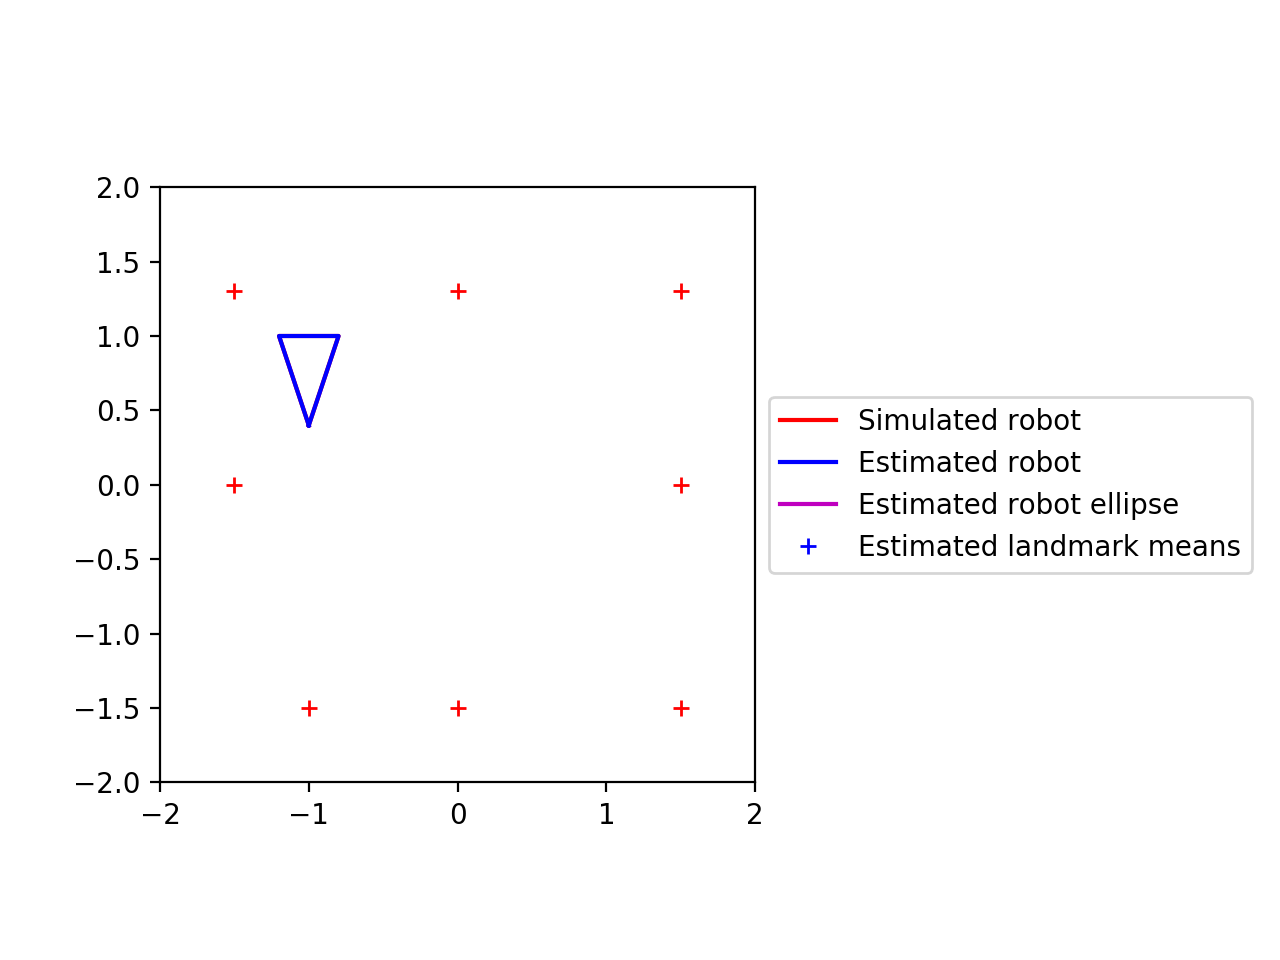

In [118]:
# waypoints=np.array([[-1.2,  1. ,-pi/2],
#        [-1.2,  1. ,-pi/2],
#        [-1.2, -1.2,-pi/2],
#        [-0.9, -1.2,pi/2],
#        [-0.9,  1. ,pi/2],
#        [-0.6,  1. ,-pi/2],
#        [-0.6, -1.2,-pi/2],
#        [-0.3, -1.2,pi/2],
#        [-0.3,  1. ,pi/2],
#        [ 0. ,  1. ,-pi/2],
#        [ 0. , -1.2,-pi/2],
#        [ 0.3, -1.2,pi/2],
#        [ 0.3,  1. ,pi/2],
#        [ 0.6,  1. ,-pi/2],
#        [ 0.6, -1.2,-pi/2],
#        [ 0.9, -1.2,pi/2],
#        [ 0.9,  1. ,pi/2],
#        [ 1.2,  1. ,0]])


waypoints=np.array([[-1. ,  0.8,-pi/2],
       [-1. ,  0.8,-pi/2],
       [-1. , -1. ,-pi/2],
       [-0.5, 0. ,pi/2],
       [-0.5,  0.8,pi/2],
       [ 0. ,  0.8,-pi/2],
       [ 0. , -1. ,-pi/2],
       [ 0.5, -1. ,pi/2],
       [ 0.5,  0.8,pi/2],
       [ 1. ,  0.8,0]])

# # SLAM2D A 2D EKF−SLAM algorithm with simulation and graphics.
# #
# # HELP NOTES:
# # 1. The robot state is defined by [xr;yr;ar] with [xr;yr] the position
# # and [ar] the orientation angle in the plane.
# # 2. The landmark states are simply Li=[xi;yi]. There are a number of N
# # landmarks organized in a 2−by−N matrix W=[L1 L2 ... Ln]
# # so that Li = W(:,i).
# # 3. The control signal for the robot is U=[dx;da] where [dx] is a forward
# # motion and [da] is the angle of rotation.
# # 4. The motion perturbation is additive Gaussian noise n=[nx;na] with
# # covariance Q, which adds to the control signal.
# # 5. The measurements are range−and−bearing Yi=[di;ai], with [di] the
# # distance from the robot to landmark Li, and [ai] the bearing angle from
# # the robot's x−axis.
# # 6. The simulated variables are written in capital letters,
# # R: robot
# # W: set of landmarks or 'world'
# # Y: set of landmark measurements Y=[Y1 Y2 ... YN]
# # 7. The true map is [xr;yr;ar;x1;y1;x2;y2;x3;y3; ... ;xN;yN]
# # 8. The estimated map is Gaussian, defined by
# # x: mean of the map
# # P: covariances matrix of the map
# # 9. The estimated entities (robot and landmarks) are extracted from {x,P}
# # via pointers, denoted in small letters as follows:
# # r: pointer to robot state. r=[1,2,3]
# # l: pointer to landmark i. We have for example l=[4,5] if i=1,
# # l=[6,7] if i=2, and so on.
# # m: pointers to all used landmarks.
# # rl: pointers to robot and one landmark.
# # rm: pointers to robot and all landmarks (the currently used map).
# # Therefore: x(r) is the robot state,
# # x(l) is the state of landmark i
# # P(r,r) is the covariance of the robot
# # P(l,l) is the covariance of landmark i
# # P(r,l) is the cross−variance between robot and lmk i
# # P(rm,rm) is the current full covariance −− the rest is
# # unused.
# # NOTE: Pointers are always row−vectors of integers.
# # 10. Managing the map space is done through the variable mapspace.
# # mapspace is a logical vector the size of x. If mapspace(i) = false,
# # then location i is free. Oterwise mapspace(i) = true. Use it as
# # follows:
# # * query for n free spaces: s = find(mapspace==false, n);
# # * block positions indicated in vector s: mapspace(s) = true;
# # * liberate positions indicated in vector s: mapspace(s) = false;
# # 11. Managing the existing landmarks is done through the variable landmarks.
# # landmarks is a 2−by−N matrix of integers. l=landmarks(:,i) are the
# # pointers of landmark i in the state vector x, so that x(l) is the
# # state of landmark i. Use it as follows:
# # * query 1 free space for a new landmark: i = find(landmarks(1,:)==0,1)
# # * associate indices in vector s to landmark i: landmarks(:,i) = s
# # * liberate landmark i: landmarks(:,i) = 0;
# # 12. Graphics objects are Matlab 'handles'. See Matlab doc for information.
# # 13. Graphic objects include:
# # RG: simulated robot
# # WG: simulated set of landmarks
# # rG: estimated robot
# # reG: estimated robot ellipse
# # lG: estimated landmarks
# # leG: estimated landmark ellipses

# I. INITIALIZE
# I.1 SIMULATOR −− use capital letters for variable names

objp = np.array([[-length_ofedge/2, -length_ofedge/2, 0.],
       [-length_ofedge/2, length_ofedge/2, 0.],
       [length_ofedge/2, length_ofedge/2, 0.],
       [length_ofedge/2, -length_ofedge/2, 0.]])
with open('calibration.yaml') as f:
    loadeddict = yaml.load(f)

mtx = np.array(loadeddict.get('camera_matrix'))
dist = np.array(loadeddict.get('dist_coeff'))
# axis = np.float32([[0.1,0,0], [0,0.1,0], [0,0,-0.1]]).reshape(-1,3)
mtx_fool=np.array([[625, 0.0, 303.790334392223],
                  [0.0, 625, 303.790334392223],
                  [0.0, 0.0, 1.0]])
cap = cv2.VideoCapture(0)


# W: set of external landmarks
W = np.array([[-1.0,-1.5,-1.5,0,0,1.5,1.5,1.5],[-1.5,0,1.3,-1.5,1.3,-1.5,0,1.3]]) # Type 'help cloister' for help
# NameW=np.array(['l0','l1','l2','l3','l4','l5','l6','l7'])
# N: number of landmarks
# N = size(W,2);
# 9 land marks
N=W.shape[1]
# R: robot pose [x ; y ; alpha]
R = np.vstack([-1. ,  0.8,-pi/2]);
# U: control [d x ; d alpha]
U = np.vstack([0.15 , 0.44]); # fixing advance and turn increments creates a circle
# Y: measurements of all landmarks
Y = np.zeros((2, N));
Y_c=Y
# I.2 ESTIMATOR
# Map: Gaussian {x,P}
# x: state vector's mean
x = np.zeros((R.size+W.size, 1));
# P: state vector's covariances matrix
P = np.zeros((x.size,x.size));

# System noise: Gaussian {0,Q}
q = np.vstack([.02,.1]) 
# amplitude or standard deviation
Q = np.diag(np.square(q[:,0])) # covariances matrix
# Measurement noise: Gaussian {0,S}
s = np.vstack([.1,1*pi/180]) # amplitude or standard deviation
S = np.diag(np.square(s[:,0])) # covariances matrix
# Map management
mapspace=np.full((1,x.size), False) # See Help Note #10 above.
# Landmarks management
landmarks = np.zeros((2, N),dtype=int) # See Help Note #11 above
# Place robot in map
r=np.nonzero(mapspace==False)[1][0:3] # set robot pointer
mapspace[:,r]=True # block map positions
x[r,:] = R # initialize robot states
P[np.ix_(r,r)]=0 # initialize robot covariance


# I.3 GRAPHICS −− use the variable names of simulated and estimated
# variables, followed by a capital G to indicate 'graphics'.
# NOTE: the graphics code is long but absolutely necessary.
# Set figure and axes for Map
fig, ax = plt.subplots()

# ax.axis([-5,5,-5,5]) # set axes limits
# ax.axis('square') # set 1:1 aspect ratio

# Simulated World −− set of all landmarks, red crosses
WG=Line2D(W[0,:],W[1,:],marker='+',color='r',linestyle='None')
ax.add_line(WG)
# WG=plt.plot(W[0,:],W[1,:],marker='+',color='r',linestyle='None')

# Simulated robot, red triangle
Rshape0 = 0.2*np.array([[2,-1,-1,2],[0,1,-1,0]]) # a triangle at the origin
Rshape,_,_ = ekf.fromFrame(R, Rshape0); # a triangle at the robot pose
RG=Line2D(Rshape[0,:],Rshape[1,:],color='r',linestyle='-')
ax.add_line(RG)
# RG=plt.plot(Rshape[0,:],Rshape[1,:],color='r')

# Estimated robot, blue triangle
rG = Line2D(Rshape[0,:],Rshape[1,:],color='b',linestyle='-')
ax.add_line(rG)
# rG = plt.plot(Rshape[0,:],Rshape[1,:],color='b')

# Estimated robot ellipse, magenta
# reG = plt.plot([],[],color='m')
reG = Line2D([],[],color='m',linestyle='-')
ax.add_line(reG)
# Estimated landmark means, blue crosses
lG = Line2D([],[],marker='+',color='b',linestyle='None')
ax.add_line(lG)
# lG = plt.plot([],[],marker='+',color='b',linestyle='None')

# Estimated landmark ellipses, green
leG = []
for i in range(N):
    leG.append(Line2D([],[],color='g',linestyle='-'))
#     leG += plt.plot([],[],color='g')
    ax.add_line(leG[i])
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
# ax.legend((WG,RG,rG,reG,lG,leG),('Simulated World','Simulated robot','Estimated robot','Estimated robot ellipse','Estimated landmark means','Estimated landmark ellipses'))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])
ax.legend((RG,rG,reG,lG),('Simulated robot','Estimated robot','Estimated robot ellipse','Estimated landmark means'),loc='center left', bbox_to_anchor=(1, 0.5))
fig.canvas.draw()
timestr = time.strftime("%Y%m%d-%H%M%S")
if not os.path.exists('./figs/'+timestr):
    os.makedirs('./figs/'+timestr)
plt.savefig('./figs/'+timestr+'/'+'setup'+'.pdf', bbox_inches='tight')

sleep(2)


In [111]:
control_sec=[]
dt=0.5
st=1

In [4]:
for i in range(N):
    Y_c[:,i:i+1]=ekf.observe(R, W[:,i:i+1])[0]

# d. Landmark Initialization −− one new landmark only at each iteration
lids = np.nonzero(landmarks[0,:]==0)[0]; # all non−initialized landmarks
while lids.size: # there are still landmarks to initialize
#         i=4
    i = lids[np.random.randint(lids.size)]; # pick one landmark randomly, its index is i
    l = np.nonzero(mapspace==False)[1][0:2]; # pointer of the new landmark in the map
    if l.size:# there is still space in the map
        mapspace[0,l] = True; # block map space
        landmarks[:,i:i+1] = np.vstack(l); # store landmark pointers
        # measurement
        Yi = Y_c[:,i:i+1];
        # initialization
        x[l], L_r, L_y = ekf.invObserve(x[r], Yi);
#             P[np.ix_(l,rm)] = L_r.dot(P[np.ix_(r,rm)]);
#             P[np.ix_(rm,l)] = P[np.ix_(l,rm)].T;
#             P[np.ix_(l,l)] = L_r.dot(P[np.ix_(r,r)]).dot(L_r.T) + L_y.dot(S).dot(L_y.T);
    lids = np.nonzero(landmarks[0,:]==0)[0];

dt=0.5
st=1



# II. TEMPORAL LOOP
t=0
for v,abs_gamma,bi in control_sec:
    
    t+=1
    
    curr_pose=x[r]
#     v,abs_gamma=controller_cs(curr_pose,waypoint,L,0.1,MIN_SPEED)


    gamma=initial_angle_fw*pi/180-abs_gamma
    if t==5:
        if abs(-pi/2-curr_pose[2,0])>15*pi/180:
            abs_gamma=abs_gamma-(-pi/2-curr_pose[2,0])
    if v<0:
        direction=-1
    else:
        direction=1

    U=np.vstack([v*dt,v/L*tan(gamma)*dt*direction*0.4])


    # II.1 SIMULATOR
    # a. motion
    n = q * np.random.randn(2,1); # perturbation vector

    R,_,_ = ekf.move(R, U, np.zeros((2,1)) ); # we will perturb the estimator
    # instead of the simulator
    # b. observations


#     for i in range(N):# i: landmark index  
#         v = s * np.random.randn(2,1); # measurement noise
#         Y[:,i:i+1] = observe(R, W[:,i:i+1])[0] + v;




    # II.2 ESTIMATOR
    # a. create dynamic map pointers to be used hereafter
    m = landmarks[landmarks!=0].T; # all pointers to landmarks
    rm = np.hstack([r , m]) # all used states: robot and landmarks
    # ( also OK is rm = find(mapspace); )
    # b. Prediction −− robot motion
    print 'current pos' +str(x[r])
    print 'abs_gamma: '+str(abs_gamma)
    ctl_constant_turning(int(v/true_speed_unit),abs_gamma*180/pi,dt,st,bi=bi) #actual control sent to the robot
    name_dis_bearing,frame=qrdb.QR_bearing_dis(cap,mtx,dist,mtx_fool,objp,sample_rate=20,draw=False)
    observed=name_dis_bearing.keys()
#     cv2.imshow("Results", frame)
#     cv2.waitKey(1)
    x[r], R_r, R_n = ekf.move(x[r], U, n); # Estimator perturbed with n


#     P[np.ix_(r,m)] = R_r.dot(P[np.ix_(r,m)]); # See PDF notes 'SLAM course.pdf'
#     P[np.ix_(m,r)] = P[np.ix_(r,m)].T;

    P[np.ix_(r,r)] = R_r.dot(P[np.ix_(r,r)]).dot(R_r.T) + R_n.dot(Q).dot(R_n.T);
    # c. Landmark correction −− known landmarks
    lids = np.nonzero( landmarks[0,:])[0]; # returns all indices of existing landmarks
    lids=np.intersect1d(observed,lids)
    # All observed existing landmarks     
    for i in lids:
        # expectation: Gaussian {e,E}
        l = landmarks[:, i:i+1].T[0,:]; # landmark pointer
        e, E_r, E_l = ekf.observe(x[r], x[l] ); # this is h(x) in EKF
#         e, E_r, E_l=QR_real_observe(x[r], x[l],i,name_dis_bearing)

#         rl = np.hstack([r , l]); # pointers to robot and lmk.
#         E_rl = np.hstack([E_r , E_l]); # expectation Jacobian

#         E = E_rl .dot( P[np.ix_(rl, rl)]) .dot( E_rl.T);

        E=E_r.dot( P[np.ix_(r, r)]) .dot( E_r.T)
        # measurement of landmark i
        Yi= name_dis_bearing[i]
#         Yi = Y[:, i:i+1];
        # innovation: Gaussian {z,Z}
        z = Yi - e; # this is z = y - h(x) in EKF
        # we need values around zero for angles:
        if z[1,0] > pi:
            z[1,0] = z[1,0] - 2*pi;
        if z[1,0] < -pi:
            z[1,0] = z[1,0] + 2*pi;
        Z = S + E;
        # Individual compatibility check at Mahalanobis distance of 3-sigma
        # (See appendix of documentation file 'SLAM course.pdf')
        if (z.T).dot(np.linalg.inv(Z)).dot(z) < 9:
            # Kalman gain
#             K = P[np.ix_(rm, rl)] .dot( E_rl.T) .dot( np.linalg.inv(Z)); # this is K = P*H'*Z^-1 in EKF
            K = P[np.ix_(r, r)] .dot( E_r.T) .dot( np.linalg.inv(Z))
            # map update (use pointer rm)
#             x[rm] = x[rm] + K.dot(z);
#             P[np.ix_(rm,rm)] = P[np.ix_(rm,rm)] - K.dot(Z).dot(K.T);
            x[r] = x[r] + K.dot(z);
            P[np.ix_(r,r)] = P[np.ix_(r,r)] - K.dot(Z).dot(K.T);


#     # d. Landmark Initialization −− one new landmark only at each iteration
#     lids = np.nonzero(landmarks[0,:]==0)[0]; # all non−initialized landmarks
# #     should be all observed-non-initialized landmarks
#     lids=np.intersect1d(observed,lids)
#     if lids.size: # there are still landmarks to initialize
# #         i=4
#         for i in lids:
# #         i = lids[np.random.randint(lids.size)]; # pick one landmark randomly, its index is i
#             l = np.nonzero(mapspace==False)[1][0:2]; # pointer of the new landmark in the map
#             if l.size:# there is still space in the map
#                 mapspace[0,l] = True; # block map space
#                 landmarks[:,i:i+1] = np.vstack(l); # store landmark pointers
#                 # measurement
# #                 Yi = Y[:,i:i+1];
#                 Yi= name_dis_bearing[i]
#                 # initialization
#                 x[l], L_r, L_y = ekf.invObserve(x[r], Yi);
#                 P[np.ix_(l,rm)] = L_r.dot(P[np.ix_(r,rm)]);
#                 P[np.ix_(rm,l)] = P[np.ix_(l,rm)].T;
#                 P[np.ix_(l,l)] = L_r.dot(P[np.ix_(r,r)]).dot(L_r.T) + L_y.dot(S).dot(L_y.T);


    # II.3 GRAPHICS
    # Simulated robot
    Rshape,_,_ = ekf.fromFrame(R, Rshape0);
    RG.set_data(Rshape[0,:],Rshape[1,:])

    # Estimated robot
    Rshape,_,_= ekf.fromFrame(x[r], Rshape0);
    rG.set_data(Rshape[0,:],Rshape[1,:])

    # Estimated robot ellipse
    re = x[r[0:2]]; # robot position mean
    RE = P[np.ix_(r[0:2],r[0:2])]; # robot position covariance
    xx,yy = ekf.cov2elli(re,RE,3,16); # x− and y− coordinates of contour
    reG.set_data(xx[0],yy[0])
    # Estimated landmarks
    lids = np.nonzero(landmarks[0,:])[0]; # all indices of mapped landmarks
    lx = x[landmarks[0,lids]]; # all x−coordinates
    ly = x[landmarks[1,lids]]; # all y−coordinates
    lG.set_data(lx,ly)

    # Estimated landmark ellipses −− one per landmark
    for i in lids:
        l = landmarks[:,i];
        le = x[l];
        LE = P[np.ix_(l,l)];
        xx,yy = ekf.cov2elli(le,LE,3,16);
        leG[i].set_data(xx[0],yy[0])
    fig.canvas.draw()
    plt.savefig('./figs/'+timestr+'/'+str(t)+'.pdf', bbox_inches='tight')

#     fig.canvas.flush_events()
    

IndentationError: expected an indented block (<ipython-input-4-f18751dda44e>, line 40)

In [ ]:
cv2.imshow(frame)

In [ ]:
cap.release()


In [ ]:
for i in range(10):  
    ctl_constant_turning(70,initial_angle_fw,dt,st)
    control_sec.append((70,initial_angle_fw,'fw'))

for i in range(9):
    ctl_constant_turning(70,initial_angle_fw-30,dt,st)
    control_sec.append((70,initial_angle_fw-30,'fw'))


for i in range(5):  
    ctl_constant_turning(70,initial_angle_fw,dt,st)
    control_sec.append((70,initial_angle_fw,'fw'))

for i in range(2):
    ctl_constant_turning(70,initial_angle_fw-30,dt,st)
    control_sec.append((70,initial_angle_fw-30,'fw'))

for i in range(5):  
    ctl_constant_turning(70,initial_angle_fw,dt,st)
    control_sec.append((70,initial_angle_fw,'fw'))

for i in range(10):  
    ctl_constant_turning(70,initial_angle_fw+30,dt,st)
    control_sec.append((70,initial_angle_fw+30,'fw'))

for i in range(4):    
    ctl_constant_turning(70,initial_angle_fw-30,dt,st,di='bw')

for i in range(5):  
    ctl_constant_turning(70,initial_angle_fw,dt,st)
    control_sec.append((70,initial_angle_fw,'fw'))

for i in range(2):
    ctl_constant_turning(70,initial_angle_fw+30,dt,st)
    control_sec.append((70,initial_angle_fw+30,'fw'))

for i in range(5):  
    ctl_constant_turning(70,initial_angle_fw,dt,st)
    control_sec.append((70,initial_angle_fw,'fw'))